# Linear Regression Models


Linear regression is a very good choice for modeling a continuous target, assuming that our features and target have certain qualities.

In this chapter, we will cover the following topics:
- key concepts
- linear regression and gradient descent
- using classical linear regression
- using lasso regression
- using non-linear regression
- regression with gradient descent

## Key Concepts

### Key assumptions of linear regression models

- there is a linear relationship between features (independent variables) and the target (dependent variable)
- the residuals (the difference between actual and predicted valeus) are normally distributed
- the residuals are independent across observations
- the variance of residuals is constant


Our residuals are sometimes not normally distributed. This can indicate that our model is less accurate along certain ranges of our target. This can happen when the relationship with the target is __nonlinear__.

There are several reasons why residuals may not be independent. This is often the case with time series data. For a model of daily stock price, the residuals may be correlated for adjacent days. This is referred to as __autocorrelation__.

It is not uncommon for our residuals to have greater variability along different ranges of a feature. __Heteroscedasticity__ is a condition where the variance of the residuals is not constant across the range of the independent variable. Heteroscedasticity can lead to non-normally distributed residuals because the variance of the residuals is not constant.

## Linear regression and ordinary least squares

OLS selects coefficients that minimize the sum of the squared distance between the actual target values and the predicted values.

## Linear regresion and gradient descent

We can use gradient descent, rather than OLS, to estimate our linear regression parameters. Gradient descent iterates over possible coefficient values to find those that minimize the residual sum of squares. 

It starts with with random coefficient valeus and calculate the sum of the squared errors for that iteration. Then, it generates new values for coefficients that yield smaller residuals that those from the previous step. 

We specify a learning rate when using gradient descent. The learning rate determines the amount of improvement in residuals at each step.

Gradient descent can often be a good choice when working with very large datasets. It may be the the only choice if the full dataset does not fit into your machine's memory.

## Using classical linear regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmet
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from data.load import load_fossilfueltaxrate14
from preprocfunc import OutlierTrans

In [2]:
ff_tax_rate14 = load_fossilfueltaxrate14()
ff_tax_rate14.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, AFG to ZWE
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    154 non-null    object 
 1   region                     154 non-null    object 
 2   region_wb                  154 non-null    object 
 3   year                       154 non-null    int64  
 4   gas_tax_imp                154 non-null    float64
 5   bmgap_diesel_spotprice_la  146 non-null    float64
 6   fuel_income_dependence     152 non-null    float64
 7   national_income_per_cap    152 non-null    float64
 8   VAT_Rate                   151 non-null    float64
 9   gov_debt_per_gdp           139 non-null    float64
 10  polity                     151 non-null    float64
 11  democracy_polity           151 non-null    float64
 12  autocracy_polity           151 non-null    float64
 13  goveffect                  154 non-null    float64
 1

In [3]:
ff_tax_rate14.head()

,country,region,region_wb,year,gas_tax_imp,bmgap_diesel_spotprice_la,fuel_income_dependence,national_income_per_cap,VAT_Rate,gov_debt_per_gdp,polity,democracy_polity,autocracy_polity,goveffect,democracy_index,democracy,nat_oil_comp,nat_oil_comp_state,motorization_rate
countrycode,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Asia + Pacific,South Asia,2014,0.272083,0.454003,0.000000,630.0,3.5,8.700291,-1.0,0.0,0.0,-1.33,0.374292,0,0.0,0.0,0.046837
AGO,Angola,Africa,Sub-Saharan Africa,2014,-0.150713,-0.225997,32.499064,5010.0,10.0,39.809857,-2.0,0.0,0.0,-1.12,0.220831,0,1.0,1.0,0.031178
ALB,Albania,Europe + North America,Europe & Central Asia,2014,1.099843,0.974003,2.292260,4540.0,20.0,70.027863,9.0,1.0,0.0,-0.09,0.529352,1,1.0,1.0,0.156796
ARE,UAE,Middle East,Middle East & North Africa,2014,-0.334680,-0.095997,18.048514,44370.0,0.0,NaN,-8.0,0.0,1.0,1.44,0.120726,0,1.0,1.0,0.212716
ARG,Argentina,Latin America & Caribbean,Latin America & Caribbean,2014,0.705042,0.594003,2.954761,12350.0,21.0,43.586674,8.0,1.0,0.0,-0.16,0.782024,1,1.0,0.0,0.313479


We separate the features into numerical and binary features. We will put `motorization_rate` into a special category because we anticipate having to do a little more with it than with the other features:

In [4]:
num_cols = [
    "fuel_income_dependence",
    "national_income_per_cap",
    "VAT_Rate",
    "gov_debt_per_gdp",
    "polity",
    "goveffect",
    "democracy_index",
]
dummy_cols = [
    "democracy_polity",
    "autocracy_polity",
    "democracy",
    "nat_oil_comp",
    "nat_oil_comp_state",
]
spec_cols = ["motorization_rate"]
target_col = ["gas_tax_imp"]

In [5]:
ff_tax_rate14[target_col + num_cols + spec_cols].agg(
    ["count", "min", "median", "max"]
).T

,count,min,median,max
gas_tax_imp,154.0,-0.800521,0.524398,1.734047
fuel_income_dependence,152.0,0.000000,0.135366,34.428455
national_income_per_cap,152.0,260.000000,6050.000000,104540.000000
VAT_Rate,151.0,0.000000,16.500000,27.000000
gov_debt_per_gdp,139.0,0.545311,39.301174,194.755470
polity,151.0,-10.000000,7.000000,10.000000
goveffect,154.0,-2.040000,-0.145000,2.180000
democracy_index,152.0,0.025098,0.572551,0.930208
motorization_rate,127.0,0.002870,0.198289,0.810421


^ Our target `gax_tax_imp` has a median value of 0.52.

- more than half of the countries have a `polity` score of 7 or higher; 10 is the highest possible `polity` score, meaning most democratic
- most countries have a negative value for government effectiveness (`goveffect`)
`democracy_index` is a very similar measure to `polity`, though there is more variation

Let's also look at tehe distribution of the binary features. We must set `normalize` to `True` to generate ratios rather than counts.


In [6]:
ff_tax_rate14[dummy_cols].apply(pd.value_counts, normalize=True).T

,0.0,1.0
democracy_polity,0.410596,0.589404
autocracy_polity,0.887417,0.112583
democracy,0.415584,0.584416
nat_oil_comp,0.539474,0.460526
nat_oil_comp_state,0.769737,0.230263


^ observations:
- the `democracy_polity` and `autocracy_polity` featuers are just binarized versions of the `polity` feature; very high `polity` scores get `democracy_polity` values of 1, while very low `polity` scores get `autocracy_polity` values of 1.
- similarly, `democracy` is a dummy feature of those countries with high `democracy_index` values.
- interestingly, nearly half of the countries (0.46) have a national oil company, and almost a quarter (0.23) have a state-owned national oil company

Preprocessing steps:
- we need to do some work on the missing values for several features
- we also need to do some scaling, but there is no need to do any encoding because we can use the binary featuers as they are
- some features are correlated, so we need to do some feature elimination

In [7]:
target = ff_tax_rate14[target_col]
features = ff_tax_rate14[num_cols + dummy_cols + spec_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0
)

In [8]:
std_trans = make_pipeline(
    OutlierTrans(2), SimpleImputer(strategy="median"), StandardScaler()
)
cat_trans = make_pipeline(SimpleImputer(strategy="most_frequent"))
spc_trans = make_pipeline(OutlierTrans(2), StandardScaler())
col_trans = ColumnTransformer(
    [
        ("stand", std_trans, num_cols),
        ("cat", cat_trans, dummy_cols),
        ("spec", spc_trans, spec_cols),
    ],
    verbose_feature_names_out=False,
)

In [9]:
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=7)

pipe1 = make_pipeline(col_trans, KNNImputer(n_neighbors=5), rfe, lr)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())
ttr.fit(X_train, y_train)

sel_cols = X_train.columns[ttr.regressor_.named_steps["rfe"].support_]
coefs = ttr.regressor_.named_steps["linearregression"].coef_

list(zip(sel_cols, coefs))

[('VAT_Rate', 0.44753064726665703),
 ('gov_debt_per_gdp', 0.12368913577287777),
 ('goveffect', 0.17926454403985637),
 ('autocracy_polity', -0.22100930246392825),
 ('nat_oil_comp', -0.15726572731003757),
 ('nat_oil_comp_state', -0.701345468663265),
 ('motorization_rate', 0.13855012574945397)]

In [10]:
y_pred = ttr.predict(X_test)
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.gas_tax_imp - pred_df.prediction

In [11]:
pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean       -0.088965
median     -0.128688
skew        0.613088
kurtosis    0.037539
Name: resid, dtype: float64

^ There is a little positive skew and some overall bias; the residuals are negative overall.

In [17]:
print(
    "MAE: {:.2f}, R-squared: {:.2f}".format(
        skmet.mean_absolute_error(y_test, y_pred), skmet.r2_score(y_test, y_pred)
    )
)

MAE: 0.23, R-squared: 0.75


^ We get a mean absolute error of 0.23. That's not a great average error, given that the median svalue for the gas tax price is 0.52. The r-squared is decent, however.

It is usually helpful to look at a plot of the residuals. 

(-0.5625, 0.8125)

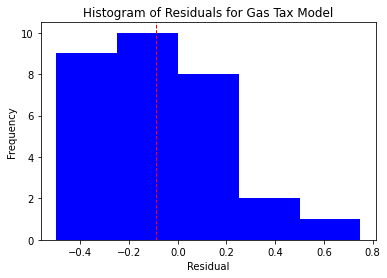

In [19]:
plt.hist(pred_df.resid, color="blue", bins=np.arange(-0.5, 1.0, 0.25))
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residuals for Gas Tax Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim()

^ This plot shows the positive skew. Morever, our model is somewhat more likely to over-predict the gas tax than under-predict it. (The residual is negative when the prediction is greater than the actual target value). 

Text(0, 0.5, 'Residuals')

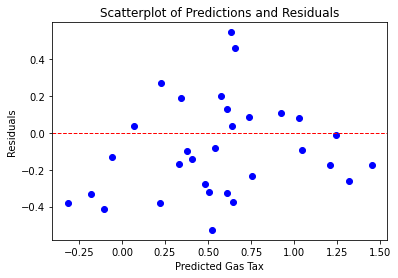

In [21]:
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gas Tax")
plt.ylabel("Residuals")

^ Here, overprediction occurs throughout the range of predicted values, but there are no underprediction (positive residuals) with predictions below 0 or above 1. This should give us some doubts about our assumption of linearity.